# Introduction

RAG stands for Retrieval Augmented Generation.
The goal of RAG is to take the information and pass it to an LLM so it can generate outputs based on that information. 

* Retrieval - Find relevant information given a query, e.g. If we have a document then based on the given qurey, we find relevant information from that document.

* Augment - We take the retrieved information and augment it (modify it a little) and pass it to the LLM as a prompt.

* Generation - use the prompt that was generated in the above two steps and generate outputs.

The main goal is using a RAG is to generate output that is relevant to our needs. Asking a LLM straightaway will give us a very general answer as the LLMs are trained on a very large dataset and can provide only overviews for any query.

1) RAGs help prevent hallucinations in LLMs and generate more factual data.

2) Work with custom data - Many base LLMs are trained with internet-scale data. This means that have a great understanding of any topic but not in depth knowledge of it. 

Use cases of RAG are

* Textbook Q&A.
* Email queries.
* Customer support Q&A.

many more.

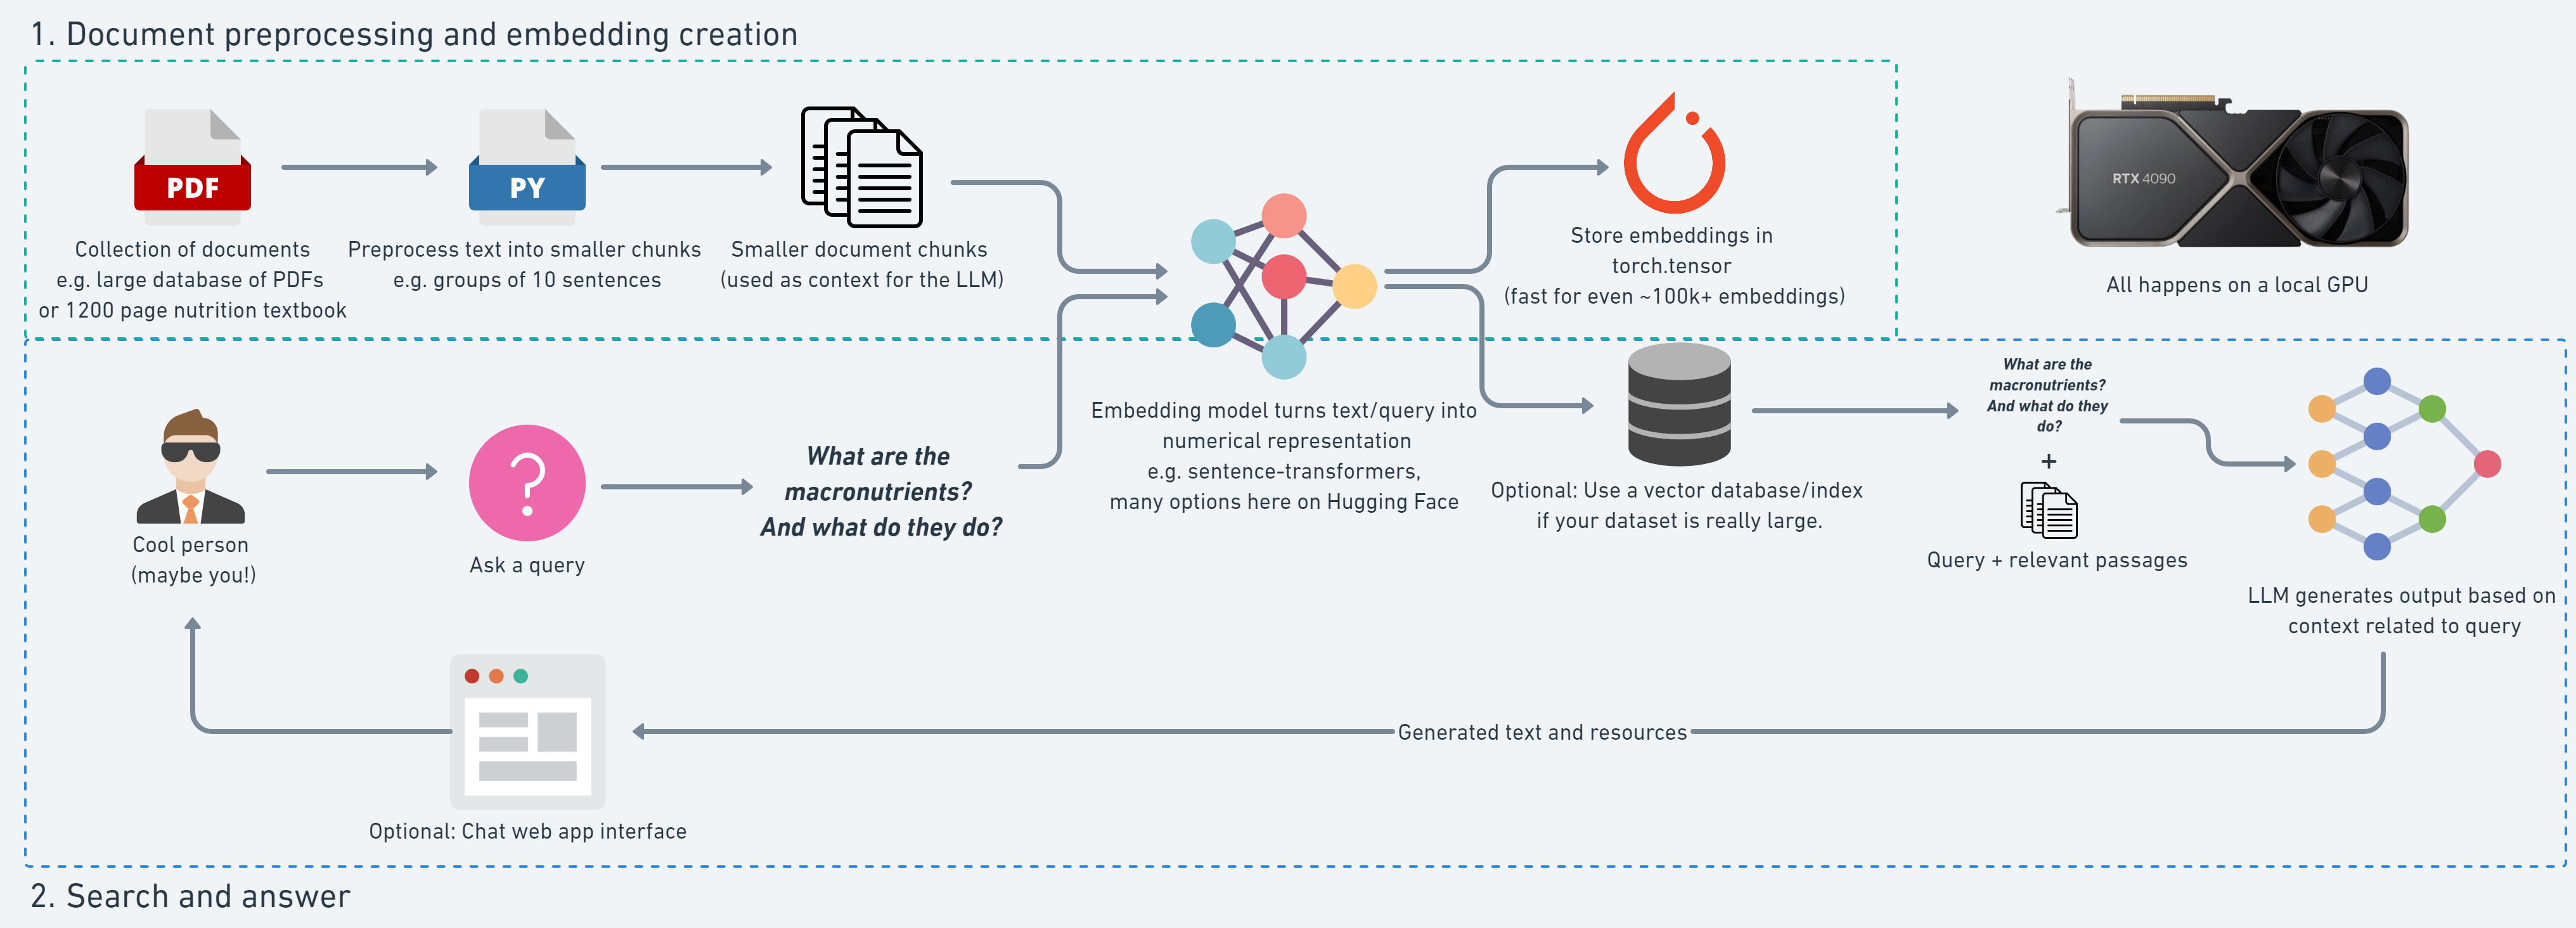

1) use any PDF(s)

2) Format the text of the PDF textbook ready for an embedding model.

3) Embed all the chunks for text in the textbook and turn into numerical representations (embedding) which can store for later.

4) Build a retreival system that uses vector search to find relevant chunk of text based on a query.  

5) Create a prompt that incorporates the retreived pieces of text.

6) Generate an answer to query based on the passages of the PDF(s) with an LLM.

# Importing and Pre-Processing The PDF(s)

### Importing and Pre-Processing

In [1]:
"""Installs required only for google colab."""
"""import os
if "COLAB_GPU" in os.environ:
    print(f"[INFO] Running in Google Colab, installing requirements.")
    !pip install -U torch # requires torch 2.1.1+, that's why we have to install.
    !pip install PyMuPDF # for reading PDFs with Python
    !pip install tqdm
    !pip install sentence-transformers
    !pip install accelerate #quantization model loading.
    !pip install bitsandbytes
    !pip install flash-attn --no-build-isolation # for using flash attention 
    """

'import os\nif "COLAB_GPU" in os.environ:\n    print(f"[INFO] Running in Google Colab, installing requirements.")\n    !pip install -U torch # requires torch 2.1.1+, that\'s why we have to install.\n    !pip install PyMuPDF # for reading PDFs with Python\n    !pip install tqdm\n    !pip install sentence-transformers\n    !pip install accelerate #quantization model loading.\n    !pip install bitsandbytes\n    !pip install flash-attn --no-build-isolation # for using flash attention \n    '

In [2]:
import os
import requests

#Get the PDF document paths
pdf_path = r"human-nutrition-text.pdf"

#Download PDF
if not os.path.exists(pdf_path):
    print(f"[INFO] file does not exist, downloading...")

    #enter the url of the PDF
    url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

    #filepath where it should be saved
    filepath = pdf_path

    #send a GET request to the URL
    response = requests.get(url)

    #check if request was successful
    if response.status_code == 200:
        with open(filepath, 'wb') as file:
            file.write(response.content)
        print(f"[INFO] The file has been downloaded and saved as {filepath}")
    else:
        print(f"[INFO] Failed to download the file. Status Code : {response.status_code}")

else:
    print(f"File exists")

File exists


In [5]:
import fitz #comes from PyMuPDF
from tqdm.auto import tqdm
from typing import List

def text_formatter(text : str) -> str:
    """Performs minor fomratting on text.
    Replaces the next line escape character with a space."""
    cleaned_text = text.replace('/n', '').strip()

    """If other pre-processing steps need to be done, they can be
    put down here"""

    return cleaned_text

#Open PDF using fitz and get lines/pages
#Note: this only focuses on text, rather than images/figures etc.

def open_and_read_pdf(pdf_path : str) -> List[dict]:
    """
    Opens a PDF file reads its text content page by page, and collects statistics.

    Parameters:
        pdf_path (str) : The file path to the PDF document to be opened and read.

    Returns:
        List[dict] : A list of dictionaries, each containing the page number
        (adjusted), character count, word count, sentence count, token count, and the page number,
        for each page
    """ 
    doc = fitz.open(pdf_path)
    pages_and_text = []

    for page_number, page in tqdm(enumerate(doc)): #opens the document with page_number and pages as the two unique Ids
        text= page.get_text() #get text in UTF-8
        text = text_formatter(text)
        pages_and_text.append({
            "page_number": page_number - 41, #accounting for all the introductory pages.
            "page_char_count": len(text),
            "page_word_count": len(text.split(" ")),
            "page_sentence_count_raw": len(text.split(".")),
            "page_token_count": len(text)/4, #i token = 4character
            "text": text
        })

    return pages_and_text

pages_and_text = open_and_read_pdf(pdf_path = pdf_path)
pages_and_text[:2]


0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [8]:
import random
random.sample(pages_and_text, k=3) 

[{'page_number': 618,
  'page_char_count': 1632,
  'page_word_count': 227,
  'page_sentence_count_raw': 35,
  'page_token_count': 408.0,
  'text': 'calcium. In fact, in females older than nine years of age, the average \ndaily intake of calcium is only about 70 percent of the recommended \nintake. Here we will take a closer look at particular groups of people \nwho may require extra calcium intake. \n• Adolescent teens. A calcium-deficient diet is common in \nteenage girls as their dairy consumption often considerably \ndrops during adolescence. \n• Amenorrheic women and the “female athlete triad“. \nAmenorrhea refers to the absence of a menstrual cycle. \nWomen who fail to menstruate suffer from reduced estrogen \nlevels, which can disrupt and have a negative impact on the \ncalcium balance in their bodies. The “female athlete triad” is a \ncombination of three conditions characterized by amenorrhea, \ndisrupted eating patterns, and osteoporosis. Exercise-induced \namenorrhea and anor

In [9]:
"""Let's now convert the dictionary into a dataframe, in order to get some 
statistics of the data. Also to increase readability."""
import pandas as pd
df = pd.DataFrame(pages_and_text)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,42,1,80.00,Human Nutrition: 2020 \nEdition \nUNIVERSITY O...
3,-38,212,30,3,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,114,3,199.25,Contents \nPreface \nUniversity of Hawai‘i at ...


In [10]:
df.describe()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00000,1208.000000,1208.000000,1208.000000,1208.000000
mean,562.50000,1148.519868,172.305464,14.180464,287.129967
std,348.86387,560.397639,86.274039,9.544587,140.099410
min,-41.00000,0.000000,1.000000,1.000000,0.000000
25%,260.75000,762.750000,110.000000,8.000000,190.687500
50%,562.50000,1230.500000,182.500000,13.000000,307.625000
75%,864.25000,1605.000000,238.000000,19.000000,401.250000
max,1166.00000,2308.000000,394.000000,82.000000,577.000000


Let's plot the token count and sentence count per page in order to get an idea of the distribution of the text throughout the book.

<Axes: >

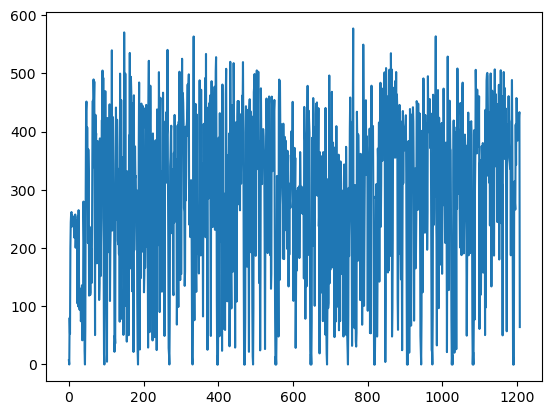

In [11]:
df['page_token_count'].plot()

<Axes: >

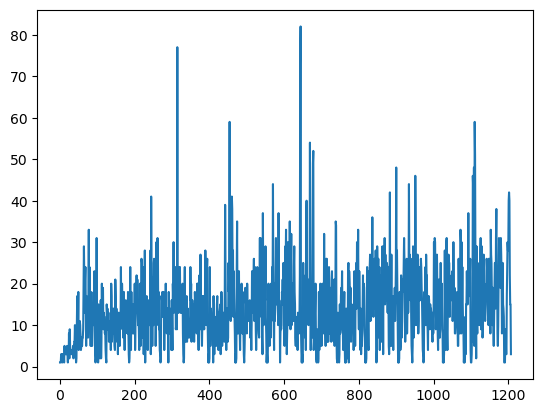

In [12]:
df['page_sentence_count_raw'].plot()

More or less, it is around 10-20 sentences per page, and the mean is 14, with a few outliers.

The ideal way of processing text before embedding it is still an active area of research.

A simple method I've found helpful is to break the text into chunks of sentences.

As in, chunk a page of text into groups of 5, 7, 10 or more sentences (these values are not set in stone and can be explored).

But we want to follow the workflow of:

`Ingest text -> split it into groups/chunks -> embed the groups/chunks 
 -> use the embeddings`

**How to do this?**

1) Either use `text.split()`, like we already did.
2) Or use NLP library such as `spaCy` or `nltk`.

spaCy : https://spacy.io/
nltk : https://www.nltk.org/


In [18]:
#Let's use spaCy
from spacy.lang.en import English

nlp = English()

#Add a sentencizer pipeline, see https://spacy.io/api/sentencizer
#sentencizer has a inbuilt list of punctuation which helps it to 
# identify end of sentences. eg. , !, ;, etc.
nlp.add_pipe("sentencizer")

#create document instance as an example
doc = nlp("This is a sentece! This is another. I like elephants.")
assert len(list(doc.sents)) == 3

#priont out our sentences split
list(doc.sents)

[This is a sentece!, This is another., I like elephants.]

In [20]:
#lets create a pipeline
for item in tqdm(pages_and_text):
    item['sentences'] = list(nlp(item['text']).sents)

    #make sure all sentences are strings
    item['sentences'] = [str(sentence) for sentence in item['sentences']]

    #count the sentences and add it as a column in dataframe
    item['page_sentence_count_spacy'] = len(item['sentences'])

df = pd.DataFrame(pages_and_text)
df

  0%|          | 0/1208 [00:00<?, ?it/s]

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text,sentences,page_sentence_count_spacy
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition,[Human Nutrition: 2020 Edition],1
1,-40,0,1,1,0.00,,[],0
2,-39,320,42,1,80.00,Human Nutrition: 2020 \nEdition \nUNIVERSITY O...,[Human Nutrition: 2020 \nEdition \nUNIVERSITY ...,1
3,-38,212,30,3,53.00,Human Nutrition: 2020 Edition by University of...,[Human Nutrition: 2020 Edition by University o...,1
4,-37,797,114,3,199.25,Contents \nPreface \nUniversity of Hawai‘i at ...,[Contents \nPreface \nUniversity of Hawai‘i at...,2
...,...,...,...,...,...,...,...,...
1203,1162,1676,217,40,419.00,39. Exercise 10.2 & 11.3 reused “Egg Oval Food...,"[39., Exercise 10.2 & 11.3 reused “Egg Oval Fo...",18
1204,1163,1617,223,22,404.25,Images / Pixabay License; “Pumpkin Cartoon Ora...,[Images / Pixabay License; “Pumpkin Cartoon Or...,10
1205,1164,1715,229,15,428.75,Flashcard Images \nNote: Most images in the fl...,[Flashcard Images \nNote: Most images in the f...,13
1206,1165,1733,233,15,433.25,ShareAlike \n11. Organs reused “Pancreas Organ...,"[ShareAlike \n11., Organs reused “Pancreas Org...",13


In [22]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.52,172.31,14.18,287.13,10.32
std,348.86,560.40,86.27,9.54,140.10,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.75,110.00,8.00,190.69,5.00
50%,562.50,1230.50,182.50,13.00,307.62,10.00
75%,864.25,1605.00,238.00,19.00,401.25,15.00
max,1166.00,2308.00,394.00,82.00,577.00,28.00


To split our groups of sentences into chunks of 10 or less, let's create a function which accepts a list as input and recursively breaks into down into sublists of a specified size.

In [23]:
from typing import List
#define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10

#create a function that recursively splits a list into desired sizes
def split_list(input_list : List, 
               slice_size : int) -> List[List[str]]:
    """Splits the input_list into sublists of size slice_size (or as close as possible),
    
    For example, a list of 17 sentences would split into two lists of[[10], [7]]
    """

    return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]

#Loop through pages and texts adn split sentences into chunks
for item in tqdm(pages_and_text):
    item['sentence_chunks'] = split_list(input_list=item['sentences'],
                                         slice_size=num_sentence_chunk_size)
    item['num_chunks'] = len(item['sentence_chunks'])

  0%|          | 0/1208 [00:00<?, ?it/s]

So far, our text dataset, `pages_and_text` contains:

* page_number
* page_char_counnt
* page_word_count 
* page_sentence_count
* page_token_count
* text : whole text on a given page.
* sentences : A list of sentences.
* sentence_chunks : A list of lists which has chunks of the sentences.
* num_chunks : The number of chunks per page.


In [34]:
df = pd.DataFrame(pages_and_text)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.52,172.31,14.18,287.13,10.32,1.53
std,348.86,560.40,86.27,9.54,140.10,6.30,0.64
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,260.75,762.75,110.00,8.00,190.69,5.00,1.00
50%,562.50,1230.50,182.50,13.00,307.62,10.00,1.00
75%,864.25,1605.00,238.00,19.00,401.25,15.00,2.00
max,1166.00,2308.00,394.00,82.00,577.00,28.00,3.00


In [40]:
pages_and_text[600]['sentence_chunks']

[['Image by \nAllison \nCalabrese / \nCC BY 4.0 \nKorsakoff syndrome can cause similar symptoms as beriberi such \nas confusion, loss of coordination, vision changes, hallucinations, \nand may progress to coma and death.',
  'This condition is specific \nto alcoholics as diets high in alcohol can cause thiamin deficiency.',
  '\nOther individuals at risk include individuals who also consume diets \ntypically low in micronutrients such as those with eating disorders, \nelderly, and individuals who have gone through gastric bypass \nsurgery.5 \nFigure 9.10 The Role of Thiamin \nFigure 9.11 Beriberi, Thiamin Deficiency \n5.',
  '\xa0Fact Sheets for Health Professionals: Thiamin.',
  'National \nInstitute of Health, Office of Dietary Supplements.',
  '\n\xa0https:/\n/ods.od.nih.gov/factsheets/Thiamin-\nHealthProfessional/. Updated Feburary 11, 2016.',
  '\nAccessed October 22, 2017.',
  '\nWater-Soluble Vitamins  |  559']]

**Splitting each chunk into its own item**

We'd Like to embed each chunk of sentence into its own numerical representation. So to do this, lets create a new list of dictionaries each containing a single chunk of sentences with relative information such as page number as well as statistics about each chunk

In [41]:
import re

#Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_text):
    for sentence_chunk in item['sentence_chunks']:
        chunk_dict = {}
        chunk_dict['page_number'] = item['page_number']

        #Join the sentences together into a paragraph like structure, aka a chunk
        joined_sentence_chunk = "".join(sentence_chunk).replace(" ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk)
        chunk_dict['sentence_chunk'] = joined_sentence_chunk

        #get stats about the chunk
        chunk_dict['chunk_char_count'] = len(joined_sentence_chunk)
        chunk_dict['chunk_word_count'] = len([word for word in joined_sentence_chunk.split()])
        chunk_dict['chunk_token_count'] = len(joined_sentence_chunk) / 4 # 1 token = ~4char

        pages_and_chunks.append(chunk_dict)

#How many chunks do we have?
len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [43]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 1098,
  'sentence_chunk': 'However, risk factors are not a 100-percent guarantee that a person \nwill develop a chronic disease, only that the conditions are right.\nFor example, if a person gets sick with the flu, we can say with \ncertainty that the illness was caused by a virus. However, we cannot \n1098  |  Threats to Health',
  'chunk_char_count': 299,
  'chunk_word_count': 53,
  'chunk_token_count': 74.75}]